Dataset de diabetes cargado correctamente.

Convirtiendo los datos a arrays de NumPy para el entrenamiento...

--- Iniciando Entrenamiento de TabNet con CrossEntropyLoss Ponderada ---


c:\Users\tcidm\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.37655 | val_0_auc: 0.83582 | val_0_logloss: 5.97306 |  0:00:03s
epoch 1  | loss: 0.25107 | val_0_auc: 0.92094 | val_0_logloss: 2.06701 |  0:00:05s
epoch 2  | loss: 0.2281  | val_0_auc: 0.95846 | val_0_logloss: 0.62175 |  0:00:08s
epoch 3  | loss: 0.21541 | val_0_auc: 0.97197 | val_0_logloss: 0.27578 |  0:00:11s
epoch 4  | loss: 0.21047 | val_0_auc: 0.97153 | val_0_logloss: 0.2175  |  0:00:14s
epoch 5  | loss: 0.20773 | val_0_auc: 0.97494 | val_0_logloss: 0.18009 |  0:00:17s
epoch 6  | loss: 0.20354 | val_0_auc: 0.97557 | val_0_logloss: 0.19496 |  0:00:20s
epoch 7  | loss: 0.20326 | val_0_auc: 0.9738  | val_0_logloss: 0.1851  |  0:00:23s
epoch 8  | loss: 0.20592 | val_0_auc: 0.97483 | val_0_logloss: 0.18676 |  0:00:26s
epoch 9  | loss: 0.20186 | val_0_auc: 0.97578 | val_0_logloss: 0.18316 |  0:00:28s
epoch 10 | loss: 0.19963 | val_0_auc: 0.97593 | val_0_logloss: 0.18997 |  0:00:31s
epoch 11 | loss: 0.19784 | val_0_auc: 0.97639 | val_0_logloss: 0.19606 |  0:00:34s
epoc

c:\Users\tcidm\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 38 | loss: 0.19006 | val_0_auc: 0.97698 | val_0_logloss: 0.18395 |  0:01:52s

Early stopping occurred at epoch 38 with best_epoch = 23 and best_val_0_logloss = 0.14045

--- Resultados de la Evaluación Final (con Pesos de Clase) ---
Puntuación AUC en el conjunto de prueba: 0.9760
Precisión (Accuracy) en el conjunto de prueba: 0.9304

Reporte de Clasificación:
              precision    recall  f1-score   support

 No Diabetes       0.99      0.94      0.96     91500
    Diabetes       0.56      0.86      0.68      8500

    accuracy                           0.93    100000
   macro avg       0.77      0.90      0.82    100000
weighted avg       0.95      0.93      0.94    100000


Matriz de Confusión:


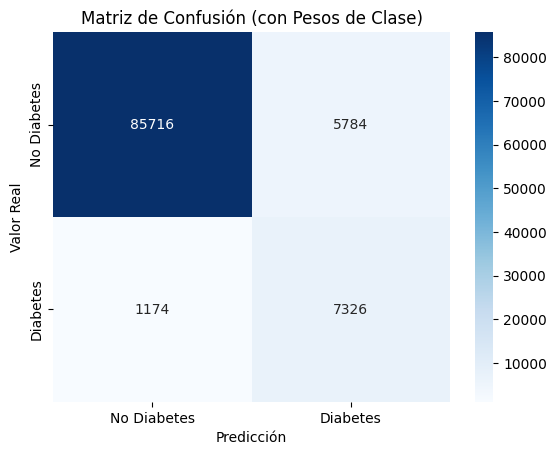


Curva de Pérdida del Entrenamiento:


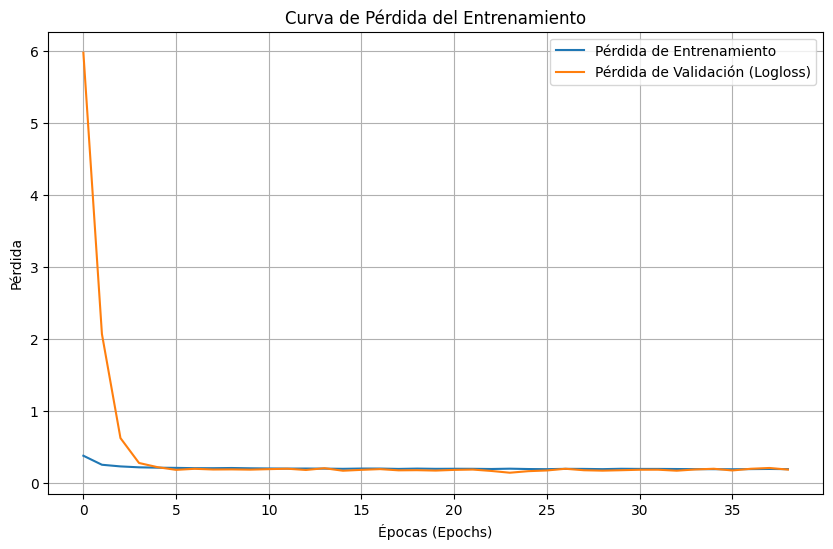


Importancia de las Características (TabNet):


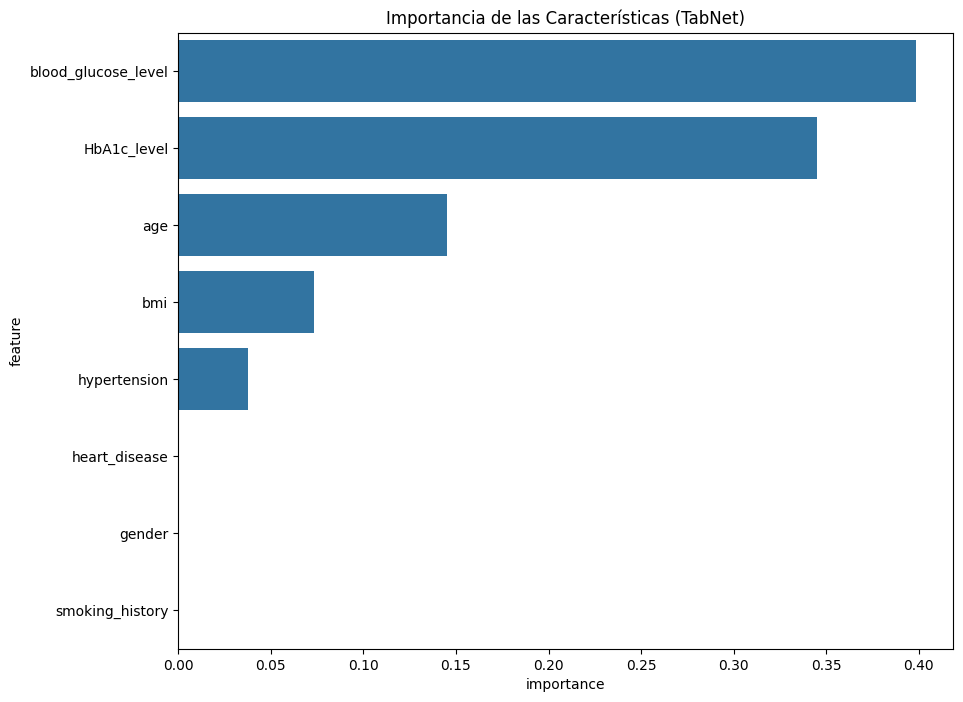

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch

try:
    df = pd.read_csv('../Datasets/dataset.csv')
    print("Dataset de diabetes cargado correctamente.")
except FileNotFoundError:
    print("Error: No se encontró el archivo 'diabetes_dataset.csv'. Por favor, verifica la ruta y el nombre.")
    exit()

target_column = 'diabetes'
categorical_features = ['gender', 'smoking_history']
numerical_features = ['age', 'hypertension', 'bmi', 'HbA1c_level', 'blood_glucose_level']

label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

df[target_column] = df[target_column].astype(int)

X = df.drop(columns=[target_column])
y = df[target_column]

feature_names = X.columns.tolist()

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nConvirtiendo los datos a arrays de NumPy para el entrenamiento...")
X_train_np = X_train.values
y_train_np = y_train.values
X_val_np = X_val.values
y_val_np = y_val.values
X_test = X.values
y_test = y.values

clf = TabNetClassifier(
    verbose=1,
    seed=42
)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
weight_tensor = torch.tensor([1.0, 10.0], device=DEVICE) 
weighted_loss_fn = torch.nn.CrossEntropyLoss(weight=weight_tensor)

print(f"\n--- Iniciando Entrenamiento de TabNet con CrossEntropyLoss Ponderada ---")
clf.fit(
    X_train=X_train_np, y_train=y_train_np,
    eval_set=[(X_val_np, y_val_np)],
    loss_fn=weighted_loss_fn,
    patience=15,
    max_epochs=100,
    eval_metric=['auc', 'logloss']
)

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

test_auc = roc_auc_score(y_test, y_pred_proba)
test_accuracy = accuracy_score(y_test, y_pred)

print("\n--- Resultados de la Evaluación Final (con Pesos de Clase) ---")
print(f"Puntuación AUC en el conjunto de prueba: {test_auc:.4f}")
print(f"Precisión (Accuracy) en el conjunto de prueba: {test_accuracy:.4f}")

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['No Diabetes', 'Diabetes']))

print("\nMatriz de Confusión:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (con Pesos de Clase)')
plt.show()

print("\nCurva de Pérdida del Entrenamiento:")
train_loss = clf.history['loss']
val_loss = clf.history['val_0_logloss']
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Pérdida de Entrenamiento')
plt.plot(val_loss, label='Pérdida de Validación (Logloss)')
plt.title('Curva de Pérdida del Entrenamiento')
plt.xlabel('Épocas (Epochs)')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

print("\nImportancia de las Características (TabNet):")
feature_importances = clf.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Importancia de las Características (TabNet)')
plt.show()